## Test Standard NBEATSx V4 + TFT V3 ##
Code to test NBEATSx Version 4 and Temporal Fusion Transformers V3 on Standard Datasets


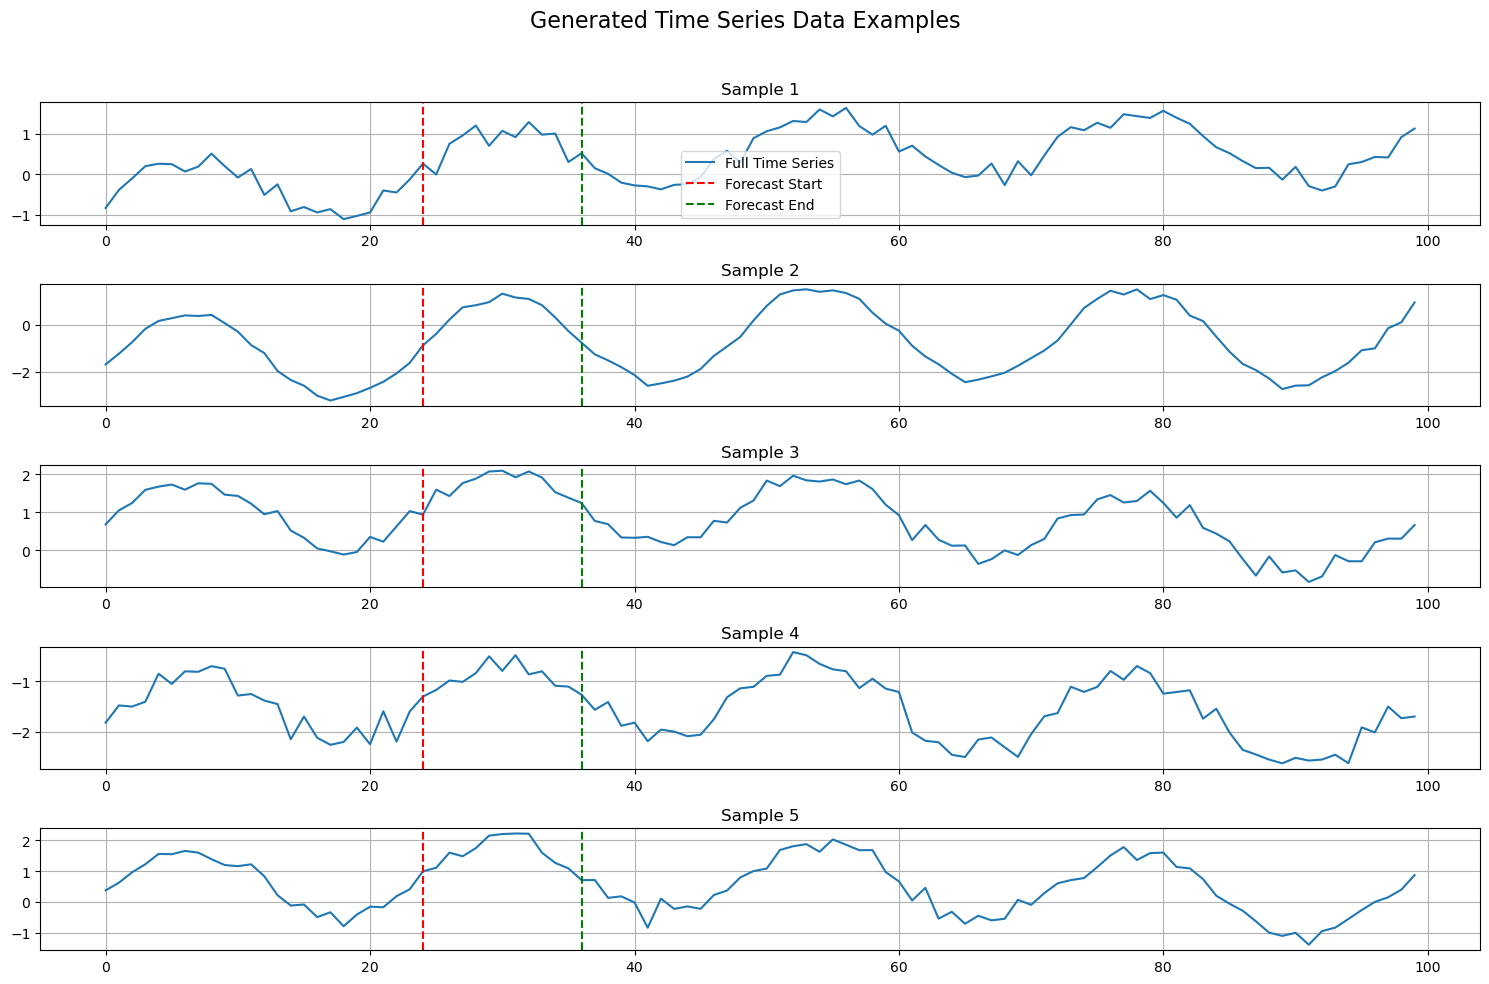

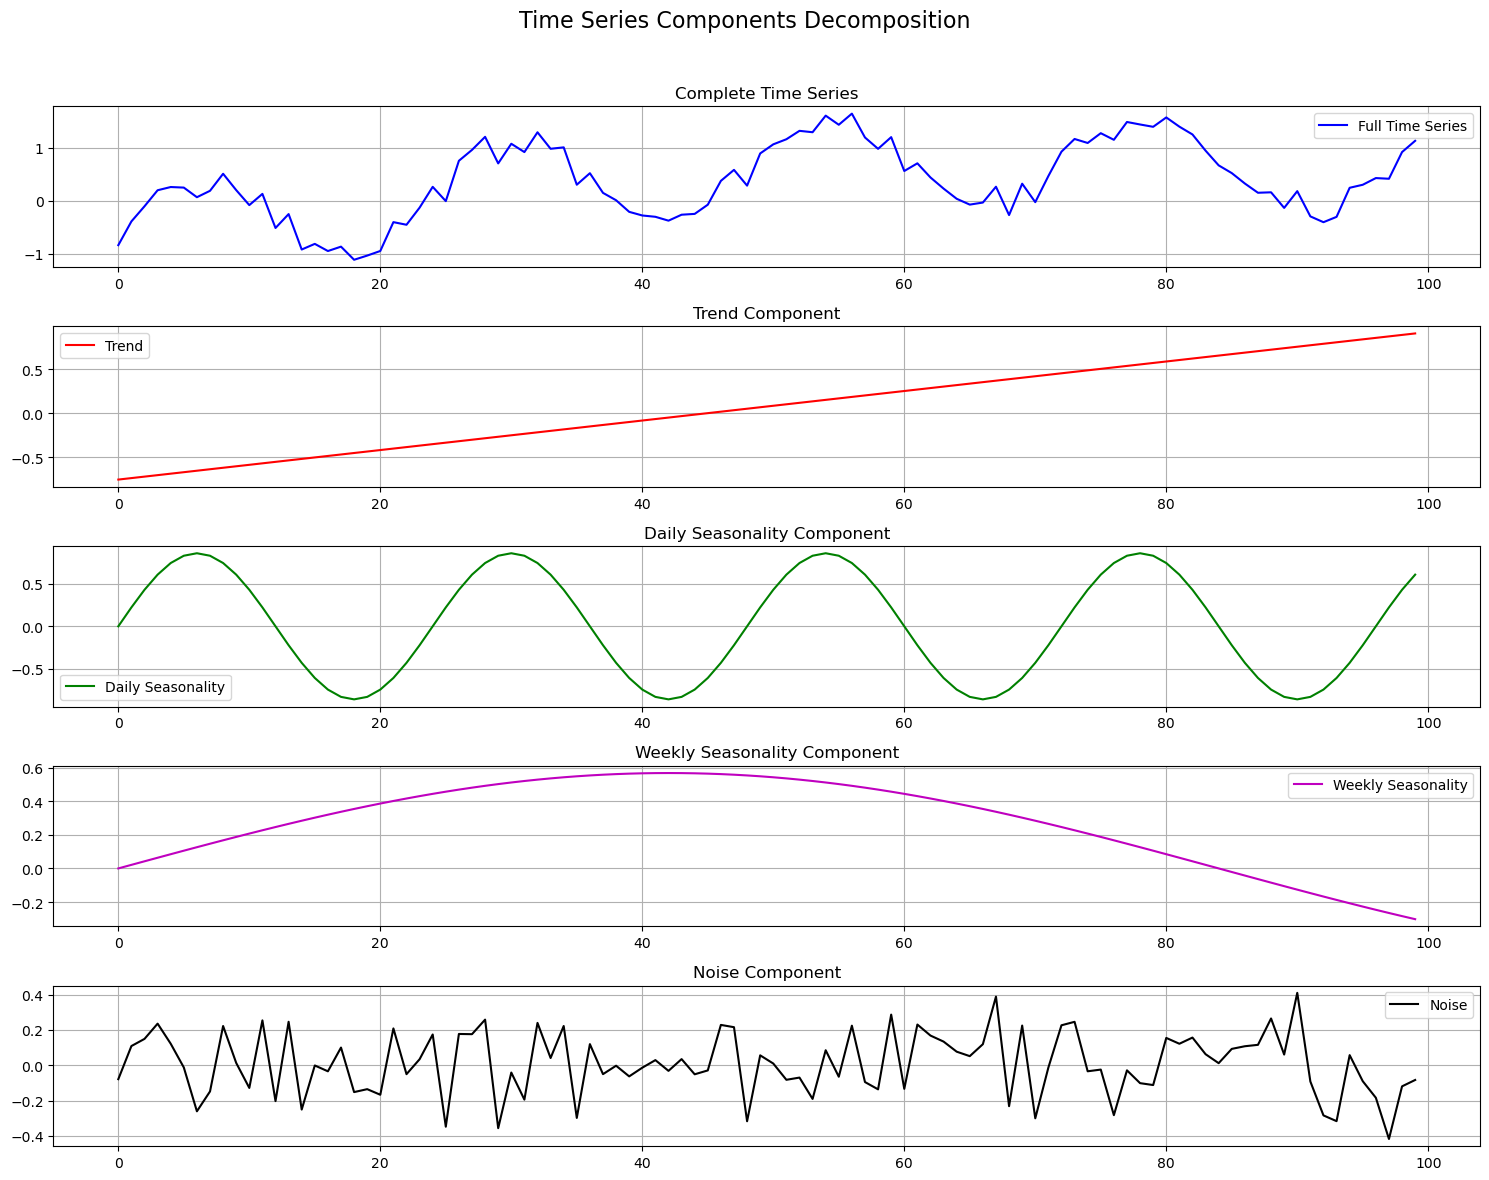

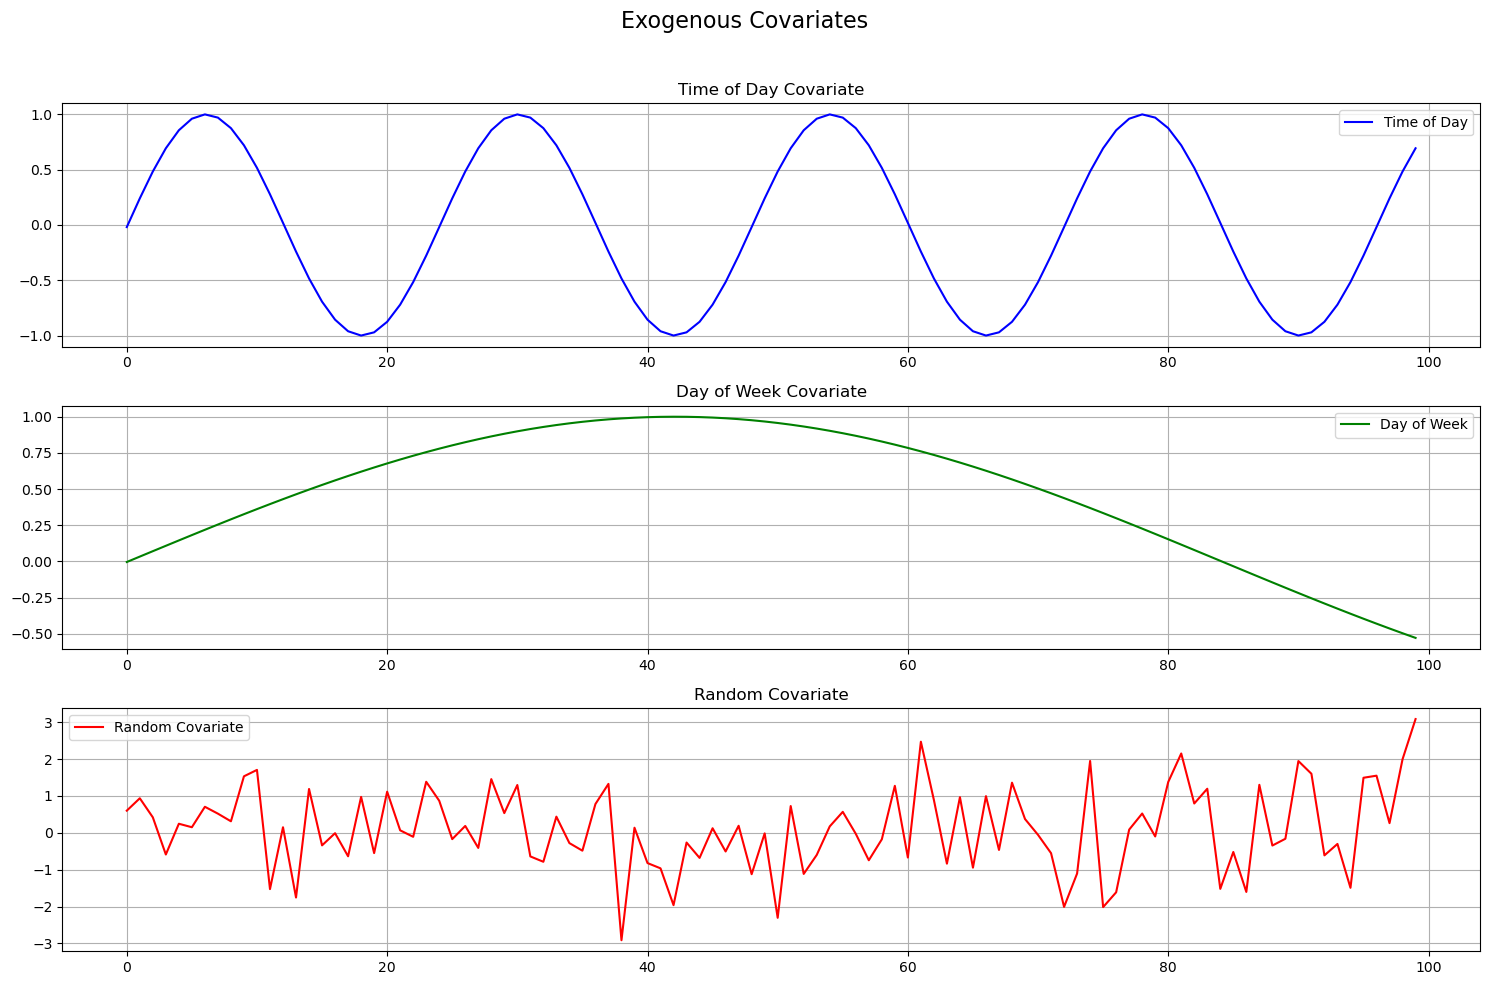

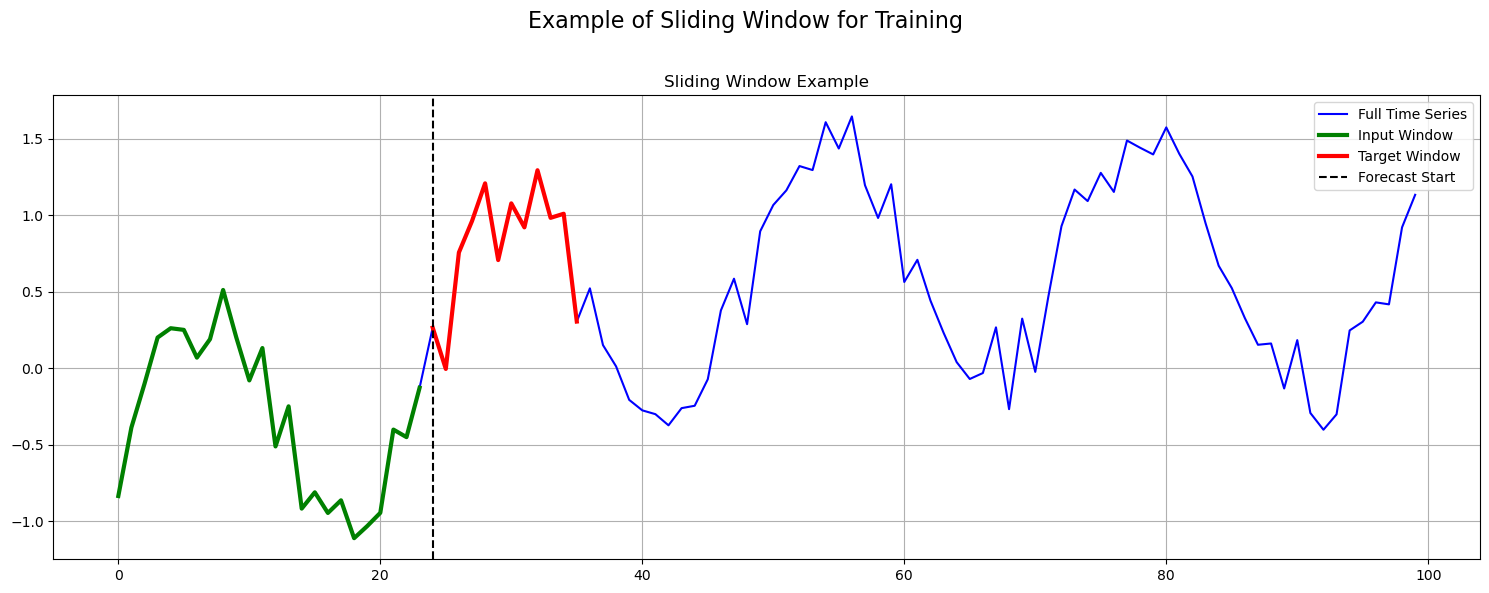

Data visualization completed.
Dataset created with 10 samples
Historical window: 24, Forecast horizon: 12

TFT Dataloader Sample:
Static inputs: [torch.Size([4, 1, 1]), torch.Size([4, 1, 1])]
Encoder inputs: [torch.Size([4, 1, 24, 1]), torch.Size([4, 1, 24, 1]), torch.Size([4, 1, 24, 1]), torch.Size([4, 1, 24, 1])]
Decoder inputs: [torch.Size([4, 1, 12, 1]), torch.Size([4, 1, 12, 2])]
Targets: torch.Size([4, 12])

NBEATSx Dataloader Sample:
X batch: torch.Size([4, 24])
Y batch: torch.Size([4, 12])
Exog batch: torch.Size([4, 24, 3])

Data generation and dataset creation successful!


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List
from sklearn.preprocessing import StandardScaler

class TimeSeriesDataset:
    """Generate synthetic time series data with trend, seasonality, and noise components"""
    
    def __init__(
        self,
        series_length: int = 200,
        n_samples: int = 100,
        backcast_length: int = 24,
        forecast_length: int = 12,
        num_covariates: int = 3,
        num_static_covariates: int = 2,
        batch_size: int = 32,
        visualize: bool = True
    ):
        self.series_length = series_length
        self.n_samples = n_samples
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length
        self.num_covariates = num_covariates
        self.num_static_covariates = num_static_covariates
        self.batch_size = batch_size
        
        # Generate data
        self.data, self.covariates, self.static_covariates, self.components = self._generate_data()
        
        # Visualize the data if requested
        if visualize:
            self.visualize_data()
        
        # Normalize data
        self.scaler = StandardScaler()
        self.data_normalized = self.scaler.fit_transform(self.data.reshape(-1, 1)).reshape(self.data.shape)
        
        # Create training, validation and test splits
        self._create_datasets()
        
    def _generate_data(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, List[np.ndarray]]:
        """Generate synthetic time series with trend, seasonality, and noise components"""
        
        # Create time vector
        t = np.arange(self.series_length)
        
        # Initialize arrays for data, covariates, and static covariates
        data = np.zeros((self.n_samples, self.series_length))
        covariates = np.zeros((self.n_samples, self.series_length, self.num_covariates))
        static_covariates = np.zeros((self.n_samples, self.num_static_covariates))
        
        # Store components for visualization
        trends = np.zeros((self.n_samples, self.series_length))
        seasonality1_components = np.zeros((self.n_samples, self.series_length))
        seasonality2_components = np.zeros((self.n_samples, self.series_length))
        noise_components = np.zeros((self.n_samples, self.series_length))
        
        for i in range(self.n_samples):
            # Generate random parameters for this time series
            trend_coef = np.random.normal(0, 0.01)
            level = np.random.normal(0, 1)
            amplitude_sin1 = np.random.normal(1, 0.3)
            amplitude_sin2 = np.random.normal(0.5, 0.15)
            noise_level = np.random.normal(0.2, 0.05)
            
            # Generate components
            trend = level + trend_coef * t
            seasonality1 = amplitude_sin1 * np.sin(2 * np.pi * t / 24)  # Daily seasonality
            seasonality2 = amplitude_sin2 * np.sin(2 * np.pi * t / (24 * 7))  # Weekly seasonality
            noise = np.random.normal(0, noise_level, self.series_length)
            
            # Store components
            trends[i] = trend
            seasonality1_components[i] = seasonality1
            seasonality2_components[i] = seasonality2
            noise_components[i] = noise
            
            # Combine components
            data[i] = trend + seasonality1 + seasonality2 + noise
            
            # Generate covariates (some correlate with the data)
            covariates[i, :, 0] = np.sin(2 * np.pi * t / 24 + np.random.normal(0, 0.1))  # Time of day
            covariates[i, :, 1] = np.sin(2 * np.pi * t / (24 * 7) + np.random.normal(0, 0.1))  # Day of week
            covariates[i, :, 2] = np.random.normal(0, 1, self.series_length)  # Random noise
            
            # Generate static covariates
            static_covariates[i, 0] = amplitude_sin1 + np.random.normal(0, 0.1)  # Correlates with daily seasonality
            static_covariates[i, 1] = trend_coef * 100 + np.random.normal(0, 0.1)  # Correlates with trend
        
        # Store components in a list
        components = [trends, seasonality1_components, seasonality2_components, noise_components]
        
        return data, covariates, static_covariates, components
    
    def visualize_data(self):
        """Visualize the generated time series data and its components"""
        
        # Plot a few examples
        num_examples = min(5, self.n_samples)
        
        # 1. Plot full time series examples
        plt.figure(figsize=(15, 10))
        plt.suptitle('Generated Time Series Data Examples', fontsize=16)
        
        for i in range(num_examples):
            plt.subplot(num_examples, 1, i + 1)
            plt.plot(self.data[i], label='Full Time Series')
            plt.axvline(x=self.backcast_length, color='r', linestyle='--', label='Forecast Start')
            plt.axvline(x=self.backcast_length + self.forecast_length, color='g', linestyle='--', label='Forecast End')
            plt.title(f'Sample {i+1}')
            plt.grid(True)
            if i == 0:
                plt.legend()
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
        
        # 2. Plot components decomposition for one example
        plt.figure(figsize=(15, 12))
        plt.suptitle('Time Series Components Decomposition', fontsize=16)
        
        # Main time series
        plt.subplot(5, 1, 1)
        plt.plot(self.data[0], 'b-', label='Full Time Series')
        plt.title('Complete Time Series')
        plt.grid(True)
        plt.legend()
        
        # Trend component
        plt.subplot(5, 1, 2)
        plt.plot(self.components[0][0], 'r-', label='Trend')
        plt.title('Trend Component')
        plt.grid(True)
        plt.legend()
        
        # Daily seasonality
        plt.subplot(5, 1, 3)
        plt.plot(self.components[1][0], 'g-', label='Daily Seasonality')
        plt.title('Daily Seasonality Component')
        plt.grid(True)
        plt.legend()
        
        # Weekly seasonality
        plt.subplot(5, 1, 4)
        plt.plot(self.components[2][0], 'm-', label='Weekly Seasonality')
        plt.title('Weekly Seasonality Component')
        plt.grid(True)
        plt.legend()
        
        # Noise component
        plt.subplot(5, 1, 5)
        plt.plot(self.components[3][0], 'k-', label='Noise')
        plt.title('Noise Component')
        plt.grid(True)
        plt.legend()
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
        
        # 3. Plot covariates
        plt.figure(figsize=(15, 10))
        plt.suptitle('Exogenous Covariates', fontsize=16)
        
        # Time of day
        plt.subplot(3, 1, 1)
        plt.plot(self.covariates[0, :, 0], 'b-', label='Time of Day')
        plt.title('Time of Day Covariate')
        plt.grid(True)
        plt.legend()
        
        # Day of week
        plt.subplot(3, 1, 2)
        plt.plot(self.covariates[0, :, 1], 'g-', label='Day of Week')
        plt.title('Day of Week Covariate')
        plt.grid(True)
        plt.legend()
        
        # Random covariate
        plt.subplot(3, 1, 3)
        plt.plot(self.covariates[0, :, 2], 'r-', label='Random Covariate')
        plt.title('Random Covariate')
        plt.grid(True)
        plt.legend()
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
        
        # 4. Plot example of window selection
        plt.figure(figsize=(15, 6))
        plt.suptitle('Example of Sliding Window for Training', fontsize=16)
        
        sample_idx = 0
        window_start = 0
        window_end = window_start + self.backcast_length
        forecast_end = window_end + self.forecast_length
        
        plt.plot(self.data[sample_idx], 'b-', label='Full Time Series')
        plt.plot(range(window_start, window_end), 
                 self.data[sample_idx, window_start:window_end], 
                 'g-', linewidth=3, label='Input Window')
        plt.plot(range(window_end, forecast_end), 
                 self.data[sample_idx, window_end:forecast_end], 
                 'r-', linewidth=3, label='Target Window')
        
        plt.axvline(x=window_end, color='k', linestyle='--', label='Forecast Start')
        plt.title('Sliding Window Example')
        plt.grid(True)
        plt.legend()
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
        
        print("Data visualization completed.")
    
    def _create_datasets(self):
        """Create training, validation and testing datasets"""
        
        # Create data windows for input/output pairs
        x_inputs = []
        y_outputs = []
        x_exog_past = []
        x_exog_future = []
        static_inputs = []
        
        # For each time series sample
        for i in range(self.n_samples):
            # For each possible window in the time series
            for j in range(self.series_length - self.backcast_length - self.forecast_length + 1):
                # Extract window
                window_start = j
                window_end = j + self.backcast_length
                
                # Target window
                target_start = window_end
                target_end = target_start + self.forecast_length
                
                # Input and output windows
                x_window = self.data_normalized[i, window_start:window_end]
                y_window = self.data_normalized[i, target_start:target_end]
                
                # Past exogenous features
                x_exog_window = self.covariates[i, window_start:window_end]
                
                # Future exogenous features
                y_exog_window = self.covariates[i, target_start:target_end]
                
                # Static covariates
                static_window = self.static_covariates[i]
                
                x_inputs.append(x_window)
                y_outputs.append(y_window)
                x_exog_past.append(x_exog_window)
                x_exog_future.append(y_exog_window)
                static_inputs.append(static_window)
        
        # Convert to numpy arrays
        x_inputs = np.array(x_inputs)
        y_outputs = np.array(y_outputs)
        x_exog_past = np.array(x_exog_past)
        x_exog_future = np.array(x_exog_future)
        static_inputs = np.array(static_inputs)
        
        # Split into train, validation, and test
        n_samples_total = len(x_inputs)
        train_end = int(0.7 * n_samples_total)
        val_end = int(0.9 * n_samples_total)
        
        # Training data
        self.x_train = torch.FloatTensor(x_inputs[:train_end])
        self.y_train = torch.FloatTensor(y_outputs[:train_end])
        self.x_exog_past_train = torch.FloatTensor(x_exog_past[:train_end])
        self.x_exog_future_train = torch.FloatTensor(x_exog_future[:train_end])
        self.static_train = torch.FloatTensor(static_inputs[:train_end])
        
        # Validation data
        self.x_val = torch.FloatTensor(x_inputs[train_end:val_end])
        self.y_val = torch.FloatTensor(y_outputs[train_end:val_end])
        self.x_exog_past_val = torch.FloatTensor(x_exog_past[train_end:val_end])
        self.x_exog_future_val = torch.FloatTensor(x_exog_future[train_end:val_end])
        self.static_val = torch.FloatTensor(static_inputs[train_end:val_end])
        
        # Test data
        self.x_test = torch.FloatTensor(x_inputs[val_end:])
        self.y_test = torch.FloatTensor(y_outputs[val_end:])
        self.x_exog_past_test = torch.FloatTensor(x_exog_past[val_end:])
        self.x_exog_future_test = torch.FloatTensor(x_exog_future[val_end:])
        self.static_test = torch.FloatTensor(static_inputs[val_end:])
        
        print(f"Dataset created with {len(self.x_train)} training samples, {len(self.x_val)} validation samples, and {len(self.x_test)} test samples")
    
    def _create_datasets(self):
        """Create training, validation and testing datasets"""
        
        # Create data windows for input/output pairs
        x_inputs = []
        y_outputs = []
        x_exog_past = []
        x_exog_future = []
        static_inputs = []
        
        # For each time series sample
        for i in range(self.n_samples):
            # For each possible window in the time series
            for j in range(self.series_length - self.backcast_length - self.forecast_length + 1):
                # Extract window
                window_start = j
                window_end = j + self.backcast_length
                
                # Target window
                target_start = window_end
                target_end = target_start + self.forecast_length
                
                # Input and output windows
                x_window = self.data_normalized[i, window_start:window_end]
                y_window = self.data_normalized[i, target_start:target_end]
                
                # Past exogenous features
                x_exog_window = self.covariates[i, window_start:window_end]
                
                # Future exogenous features
                y_exog_window = self.covariates[i, target_start:target_end]
                
                # Static covariates
                static_window = self.static_covariates[i]
                
                x_inputs.append(x_window)
                y_outputs.append(y_window)
                x_exog_past.append(x_exog_window)
                x_exog_future.append(y_exog_window)
                static_inputs.append(static_window)
        
        # Convert to numpy arrays
        x_inputs = np.array(x_inputs)
        y_outputs = np.array(y_outputs)
        x_exog_past = np.array(x_exog_past)
        x_exog_future = np.array(x_exog_future)
        static_inputs = np.array(static_inputs)
        
        # Split into train, validation, and test
        n_samples_total = len(x_inputs)
        train_end = int(0.7 * n_samples_total)
        val_end = int(0.9 * n_samples_total)
        
        # Training data
        self.x_train = torch.FloatTensor(x_inputs[:train_end])
        self.y_train = torch.FloatTensor(y_outputs[:train_end])
        self.x_exog_past_train = torch.FloatTensor(x_exog_past[:train_end])
        self.x_exog_future_train = torch.FloatTensor(x_exog_future[:train_end])
        self.static_train = torch.FloatTensor(static_inputs[:train_end])
        
        # Validation data
        self.x_val = torch.FloatTensor(x_inputs[train_end:val_end])
        self.y_val = torch.FloatTensor(y_outputs[train_end:val_end])
        self.x_exog_past_val = torch.FloatTensor(x_exog_past[train_end:val_end])
        self.x_exog_future_val = torch.FloatTensor(x_exog_future[train_end:val_end])
        self.static_val = torch.FloatTensor(static_inputs[train_end:val_end])
        
        # Test data
        self.x_test = torch.FloatTensor(x_inputs[val_end:])
        self.y_test = torch.FloatTensor(y_outputs[val_end:])
        self.x_exog_past_test = torch.FloatTensor(x_exog_past[val_end:])
        self.x_exog_future_test = torch.FloatTensor(x_exog_future[val_end:])
        self.static_test = torch.FloatTensor(static_inputs[val_end:])
    
    def get_tft_data_loaders(self):
        """Create DataLoaders specifically formatted for TFT model"""
        
        train_dataset = TFTDataset(
            self.x_train, 
            self.y_train, 
            self.x_exog_past_train,
            self.x_exog_future_train,
            self.static_train
        )
        
        val_dataset = TFTDataset(
            self.x_val, 
            self.y_val, 
            self.x_exog_past_val,
            self.x_exog_future_val,
            self.static_val
        )
        
        test_dataset = TFTDataset(
            self.x_test, 
            self.y_test, 
            self.x_exog_past_test,
            self.x_exog_future_test,
            self.static_test
        )
        
        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=self.batch_size, shuffle=True
        )
        
        val_loader = torch.utils.data.DataLoader(
            val_dataset, batch_size=self.batch_size, shuffle=False
        )
        
        test_loader = torch.utils.data.DataLoader(
            test_dataset, batch_size=self.batch_size, shuffle=False
        )
        
        return train_loader, val_loader, test_loader
    
    def get_nbeats_data_loaders(self):
        """Create DataLoaders for NBEATSx model"""
        
        train_dataset = NBEATSDataset(
            self.x_train, 
            self.y_train, 
            self.x_exog_past_train
        )
        
        val_dataset = NBEATSDataset(
            self.x_val, 
            self.y_val, 
            self.x_exog_past_val
        )
        
        test_dataset = NBEATSDataset(
            self.x_test, 
            self.y_test, 
            self.x_exog_past_test
        )
        
        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=self.batch_size, shuffle=True
        )
        
        val_loader = torch.utils.data.DataLoader(
            val_dataset, batch_size=self.batch_size, shuffle=False
        )
        
        test_loader = torch.utils.data.DataLoader(
            test_dataset, batch_size=self.batch_size, shuffle=False
        )
        
        return train_loader, val_loader, test_loader
    
    def inverse_transform(self, data):
        """Inverse transform normalized data"""
        return self.scaler.inverse_transform(data.reshape(-1, 1)).reshape(data.shape)


class TFTDataset(torch.utils.data.Dataset):
    """Dataset for Temporal Fusion Transformer"""
    
    def __init__(
        self, 
        x_data, 
        y_data, 
        past_exog,
        future_exog,
        static_data
    ):
        self.x_data = x_data
        self.y_data = y_data
        self.past_exog = past_exog
        self.future_exog = future_exog
        self.static_data = static_data
    
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, idx):
        # Prepare data in the format expected by TFT
        
        # Static inputs (batch_size, feature_dims)
        static_x = self.static_data[idx]
        
        # Time-varying historical inputs (batch_size, backcast_length, feature_dims)
        past_x = self.x_data[idx].unsqueeze(-1)  # Target variable history
        past_exog = self.past_exog[idx]  # Past covariates
        
        # Time-varying future inputs (known future covariates)
        future_exog = self.future_exog[idx]
        
        # Target values
        target_y = self.y_data[idx]
        
        # Split static features into components for TFT
        static_inputs = [static_x[:1].unsqueeze(0), static_x[1:].unsqueeze(0)]  # Example split of static features
        
        # Prepare historical time-varying features
        encoder_inputs = [
            past_x.unsqueeze(0),  # Historical target
            past_exog[:, 0:1].unsqueeze(0),  # Time of day
            past_exog[:, 1:2].unsqueeze(0),  # Day of week
            past_exog[:, 2:].unsqueeze(0),   # Random features
        ]
        
        # Prepare future time-varying features (known)
        decoder_inputs = [
            future_exog[:, 0:1].unsqueeze(0),  # Future time of day
            future_exog[:, 1:].unsqueeze(0),   # Future day of week + random features
        ]
        
        return static_inputs, encoder_inputs, decoder_inputs, target_y


class NBEATSDataset(torch.utils.data.Dataset):
    """Dataset for N-BEATS model"""
    
    def __init__(self, x_data, y_data, exog_data):
        self.x_data = x_data
        self.y_data = y_data
        self.exog_data = exog_data
    
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx]
        exog = self.exog_data[idx]
        
        return x, y, exog


# Test function to verify the data generation
def test_time_series_dataset():
    """Test the TimeSeriesDataset class"""
    # Create dataset
    dataset = TimeSeriesDataset(
        series_length=100,
        n_samples=10,
        backcast_length=24,
        forecast_length=12,
        num_covariates=3,
        num_static_covariates=2,
        batch_size=4
    )
    
    # Print dataset info
    print(f"Dataset created with {dataset.n_samples} samples")
    print(f"Historical window: {dataset.backcast_length}, Forecast horizon: {dataset.forecast_length}")
    
    # Check TFT data loaders
    train_loader, val_loader, test_loader = dataset.get_tft_data_loaders()
    
    # Check a batch from the train loader
    for static_inputs, encoder_inputs, decoder_inputs, targets in train_loader:
        print("\nTFT Dataloader Sample:")
        print(f"Static inputs: {[s.shape for s in static_inputs]}")
        print(f"Encoder inputs: {[e.shape for e in encoder_inputs]}")
        print(f"Decoder inputs: {[d.shape for d in decoder_inputs]}")
        print(f"Targets: {targets.shape}")
        break
    
    # Check NBEATSx data loaders
    train_loader, val_loader, test_loader = dataset.get_nbeats_data_loaders()
    
    # Check a batch from the train loader
    for x_batch, y_batch, exog_batch in train_loader:
        print("\nNBEATSx Dataloader Sample:")
        print(f"X batch: {x_batch.shape}")
        print(f"Y batch: {y_batch.shape}")
        print(f"Exog batch: {exog_batch.shape}")
        break
    
    print("\nData generation and dataset creation successful!")


if __name__ == "__main__":
    test_time_series_dataset()


=== Testing Time Series Data Generation ===



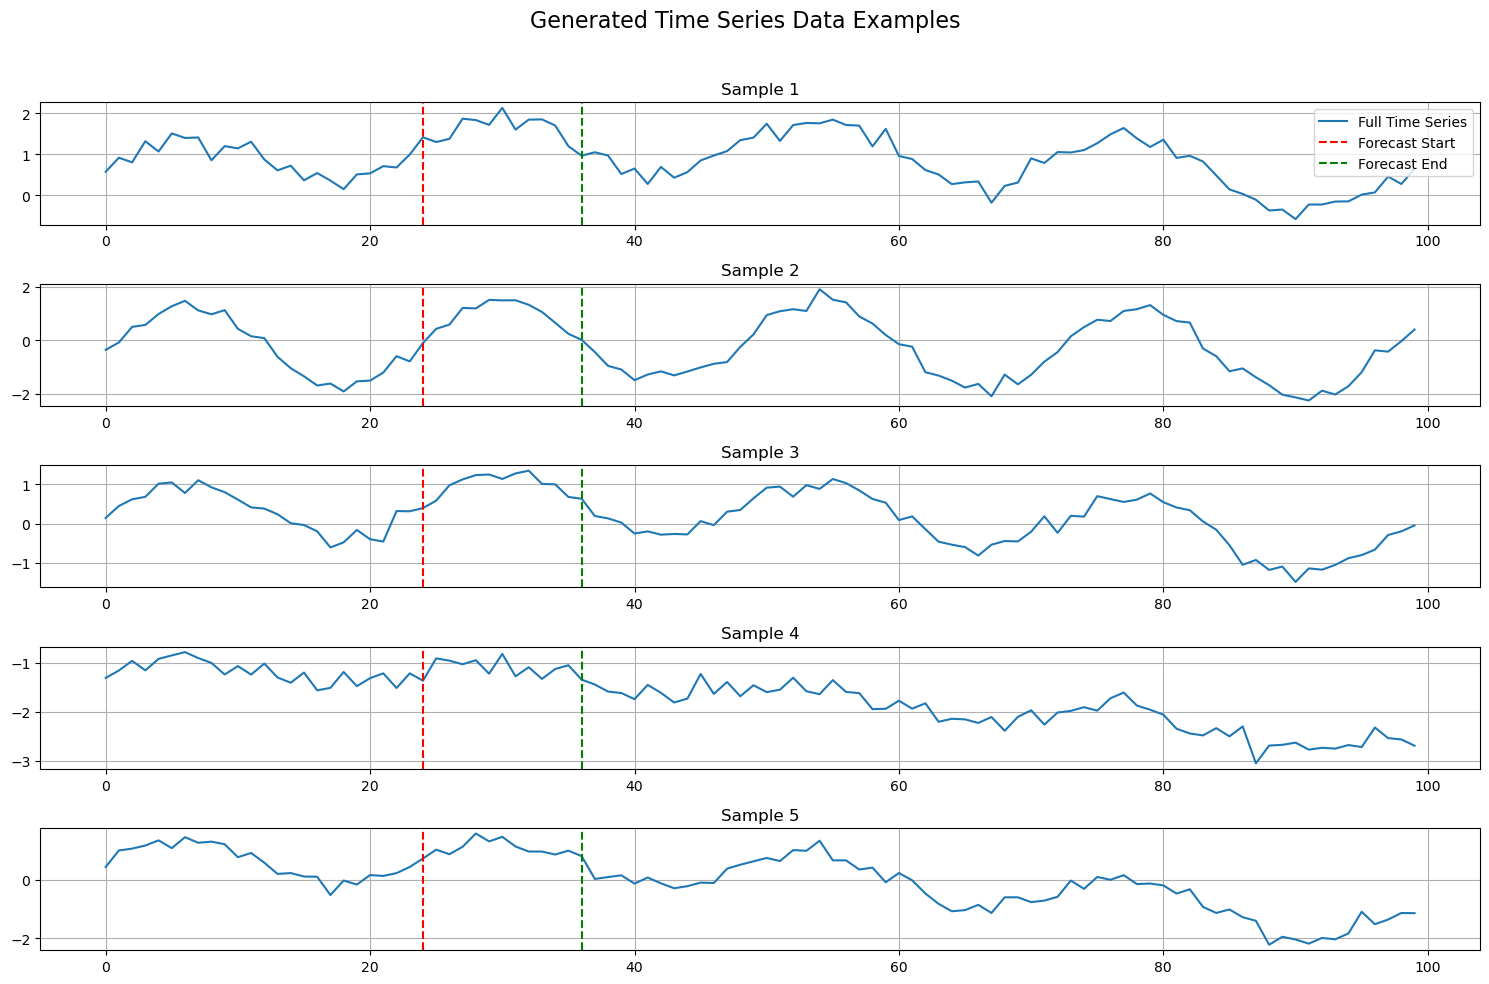

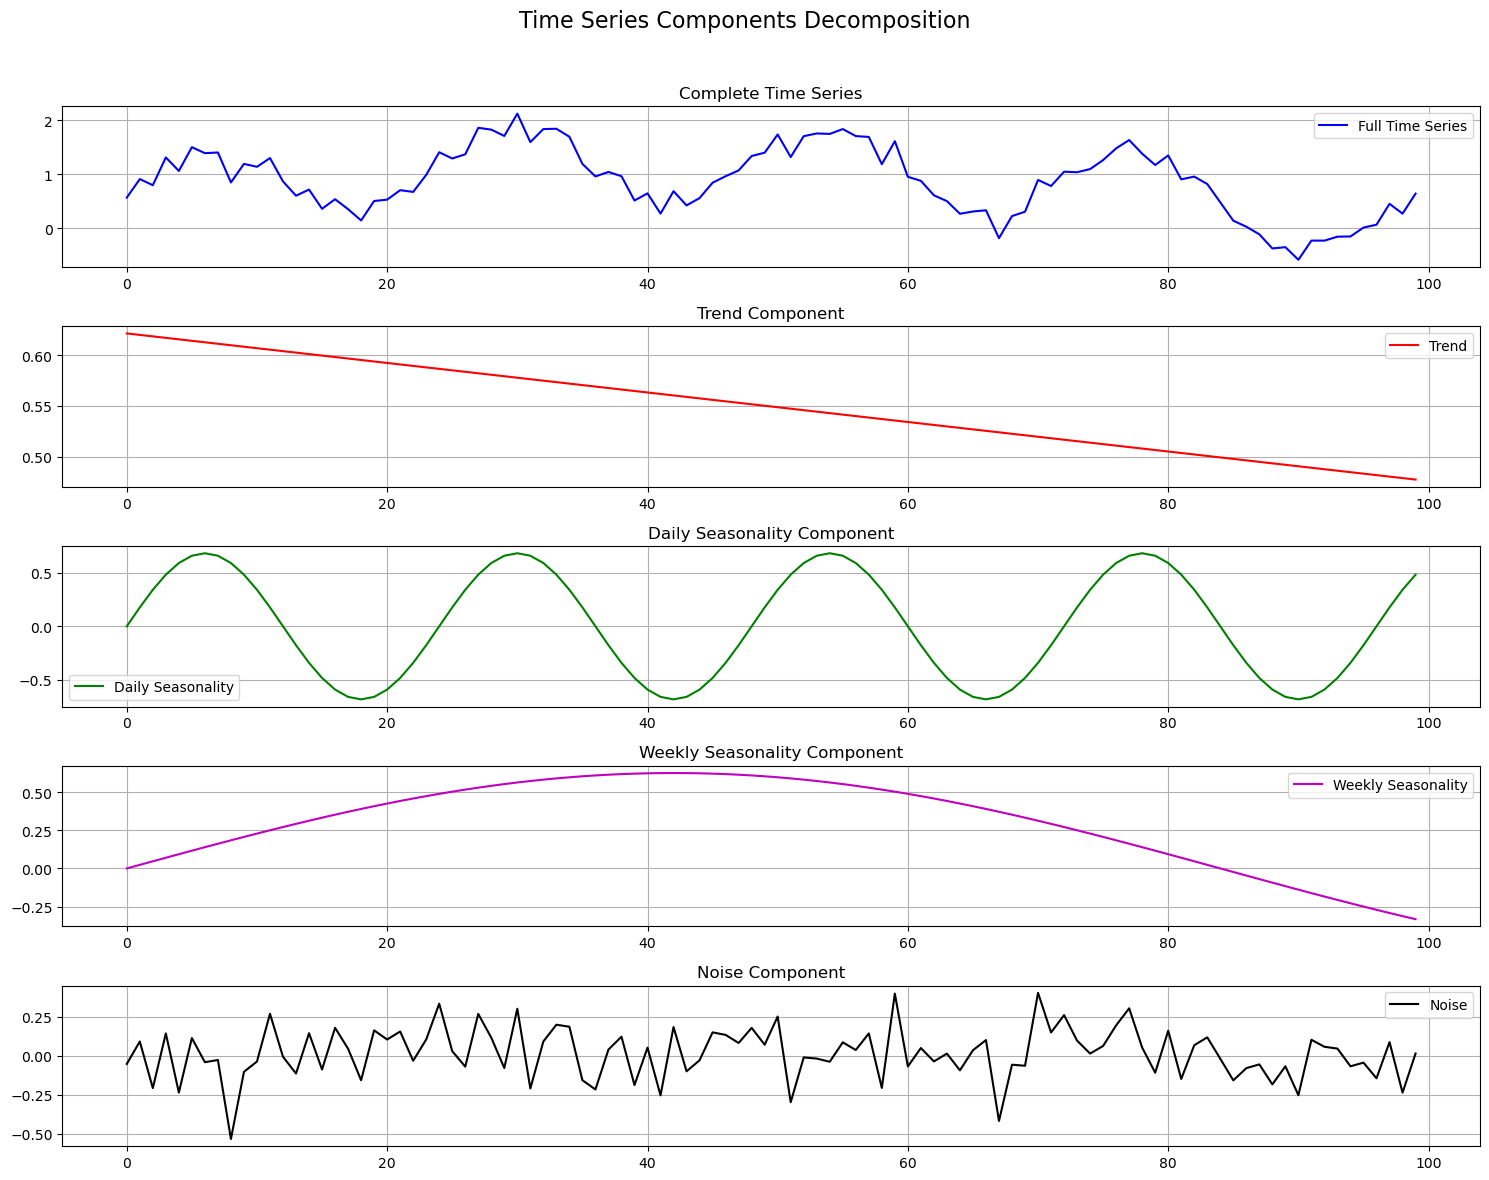

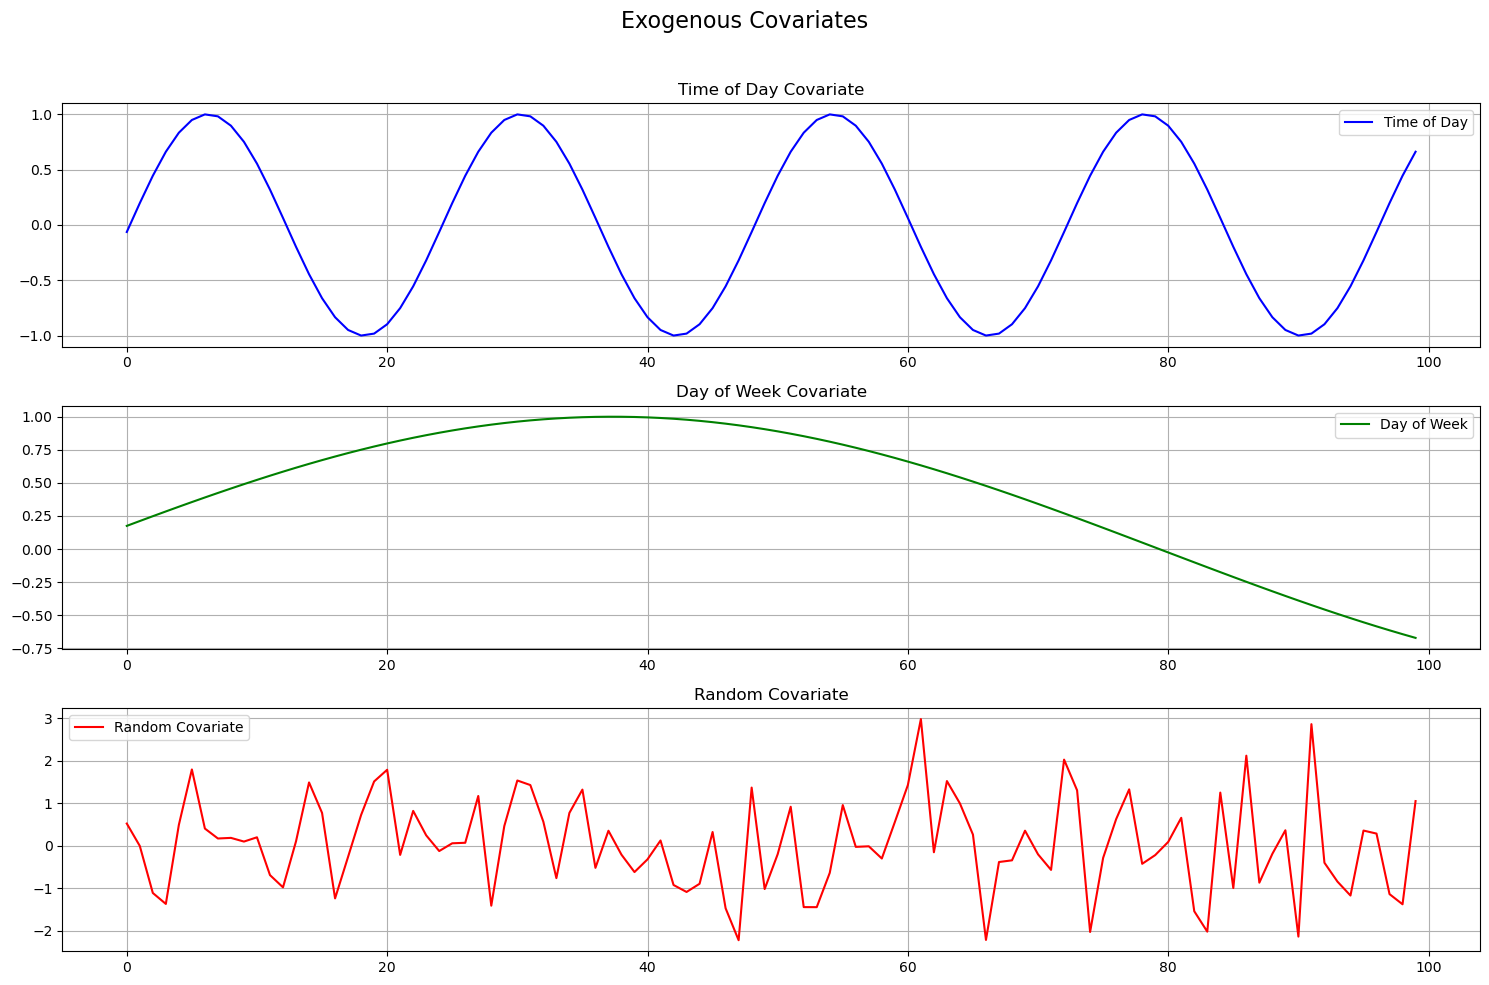

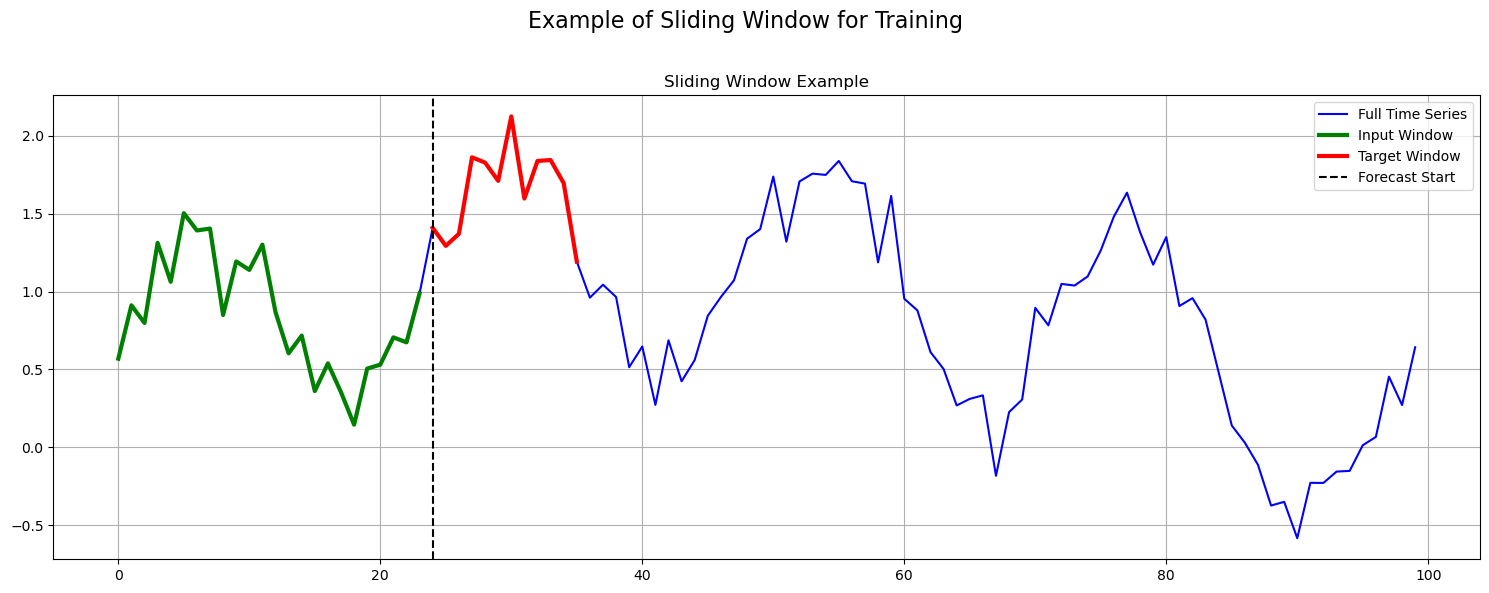

Data visualization completed.

Dataset created with 10 samples
Historical window: 24, Forecast horizon: 12

Testing TFT data loaders...

TFT Dataloader batch shapes:
Static inputs: [torch.Size([4, 1, 1]), torch.Size([4, 1, 1])]
Encoder inputs: [torch.Size([4, 1, 24, 1]), torch.Size([4, 1, 24, 1]), torch.Size([4, 1, 24, 1]), torch.Size([4, 1, 24, 1])]
Decoder inputs: [torch.Size([4, 1, 12, 1]), torch.Size([4, 1, 12, 2])]
Targets: torch.Size([4, 12])

Testing NBEATSx data loaders...

NBEATSx Dataloader batch shapes:
X batch: torch.Size([4, 24])
Y batch: torch.Size([4, 12])
Exog batch: torch.Size([4, 24, 3])


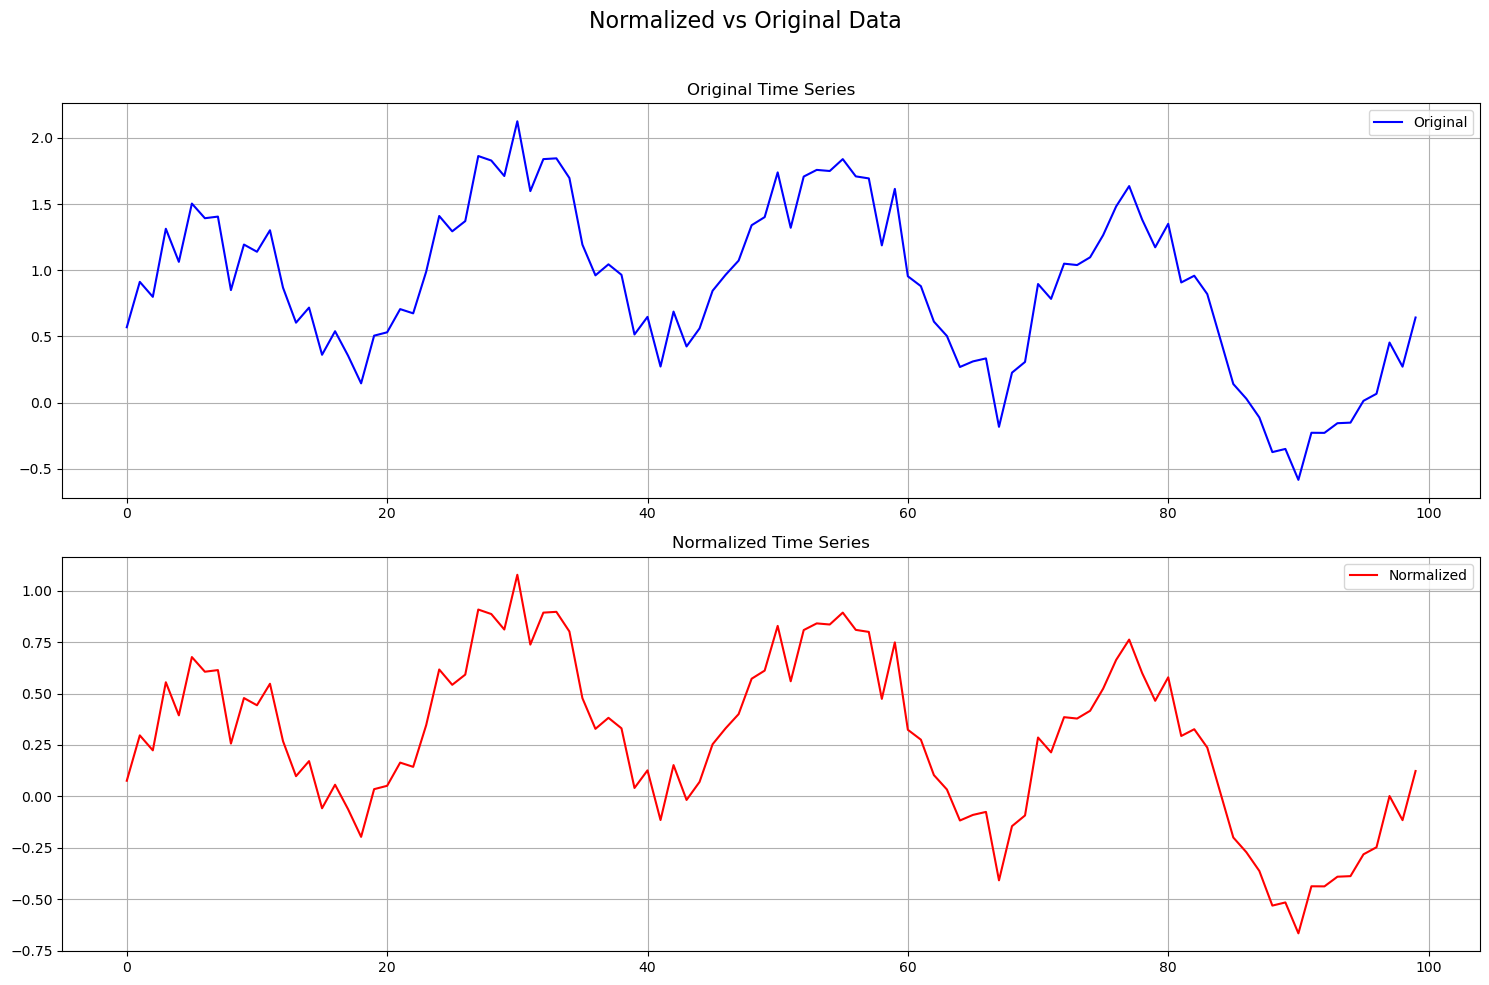

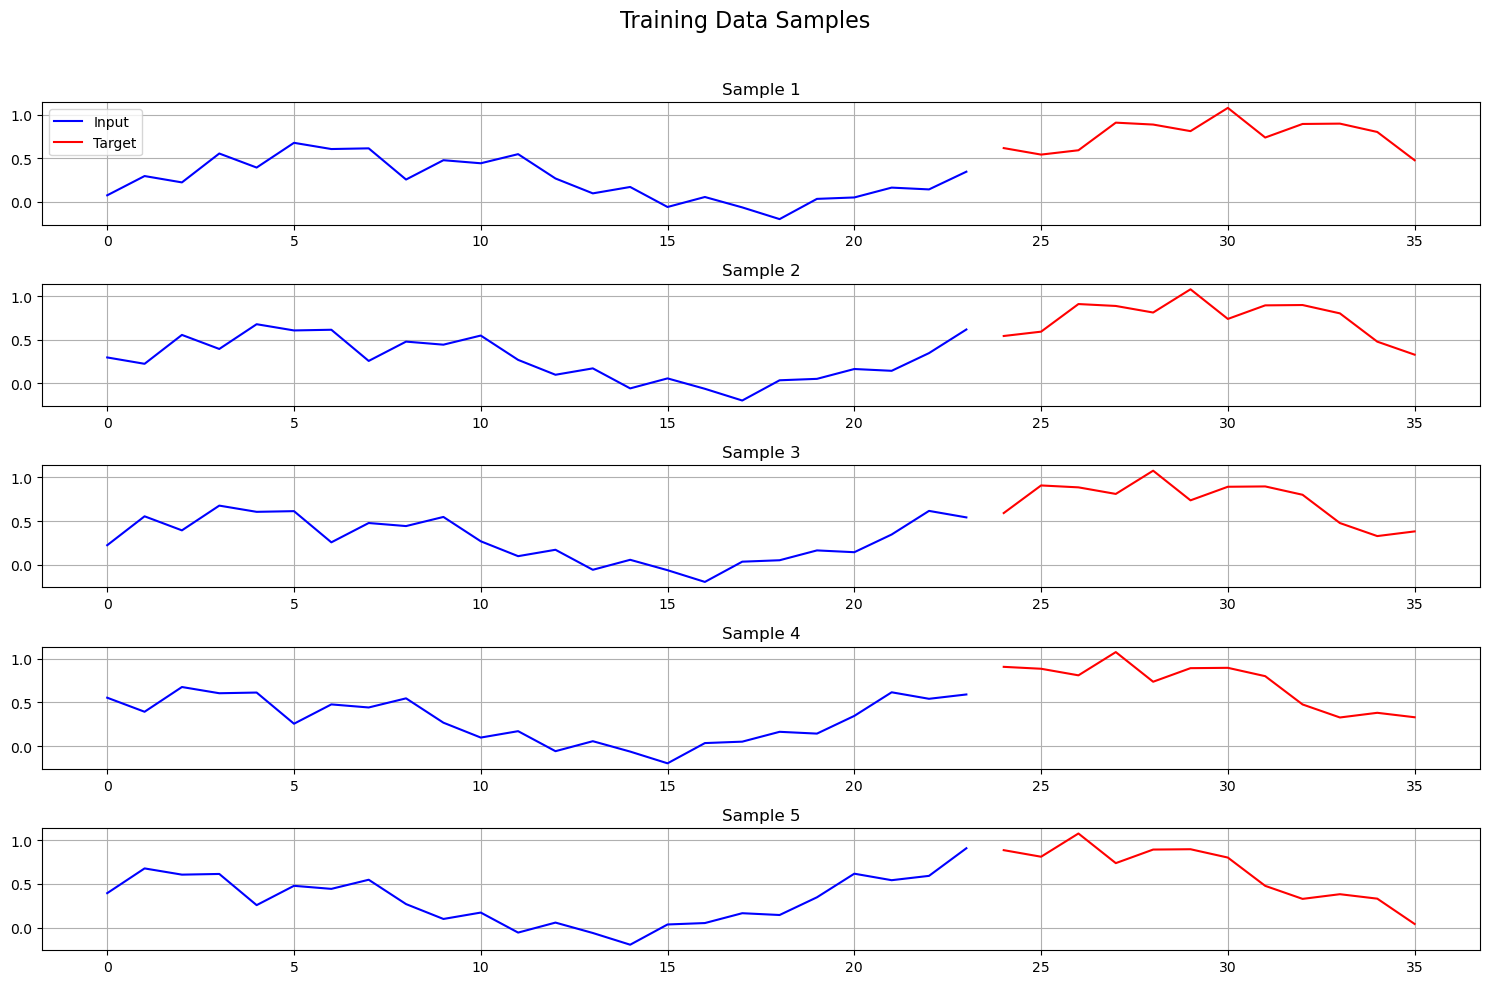


Data generation test completed successfully!


In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt
# from fixed_timeseries_dataset import TimeSeriesDataset, TFTDataset, NBEATSDataset

def test_data_generation():
    """
    Generate synthetic time series data and visualize it
    """
    print("\n=== Testing Time Series Data Generation ===\n")
    
    # Create dataset with visualization
    dataset = TimeSeriesDataset(
        series_length=100,
        n_samples=10,
        backcast_length=24,
        forecast_length=12,
        num_covariates=3,
        num_static_covariates=2,
        batch_size=4,
        visualize=True
    )
    
    # Print dataset info
    print(f"\nDataset created with {dataset.n_samples} samples")
    print(f"Historical window: {dataset.backcast_length}, Forecast horizon: {dataset.forecast_length}")
    
    # Test data loaders
    print("\nTesting TFT data loaders...")
    train_loader, val_loader, test_loader = dataset.get_tft_data_loaders()
    
    for static_inputs, encoder_inputs, decoder_inputs, targets in train_loader:
        print("\nTFT Dataloader batch shapes:")
        print(f"Static inputs: {[s.shape for s in static_inputs]}")
        print(f"Encoder inputs: {[e.shape for e in encoder_inputs]}")
        print(f"Decoder inputs: {[d.shape for d in decoder_inputs]}")
        print(f"Targets: {targets.shape}")
        break
    
    print("\nTesting NBEATSx data loaders...")
    train_loader, val_loader, test_loader = dataset.get_nbeats_data_loaders()
    
    for x_batch, y_batch, exog_batch in train_loader:
        print("\nNBEATSx Dataloader batch shapes:")
        print(f"X batch: {x_batch.shape}")
        print(f"Y batch: {y_batch.shape}")
        print(f"Exog batch: {exog_batch.shape}")
        break
    
    # Create an additional visualization of normalized data
    plt.figure(figsize=(15, 10))
    plt.suptitle("Normalized vs Original Data", fontsize=16)
    
    # Plot original and normalized for a single sample
    sample_idx = 0
    
    plt.subplot(2, 1, 1)
    plt.plot(dataset.data[sample_idx], 'b-', label='Original')
    plt.title('Original Time Series')
    plt.grid(True)
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(dataset.data_normalized[sample_idx], 'r-', label='Normalized')
    plt.title('Normalized Time Series')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
    # Visualize training samples
    plt.figure(figsize=(15, 10))
    plt.suptitle("Training Data Samples", fontsize=16)
    
    num_samples = min(5, len(dataset.x_train))
    
    for i in range(num_samples):
        plt.subplot(num_samples, 1, i+1)
        plt.plot(dataset.x_train[i].numpy(), 'b-', label='Input')
        plt.plot(range(len(dataset.x_train[i]), len(dataset.x_train[i]) + len(dataset.y_train[i])), 
                 dataset.y_train[i].numpy(), 'r-', label='Target')
        plt.title(f'Sample {i+1}')
        plt.grid(True)
        if i == 0:
            plt.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
    print("\nData generation test completed successfully!")
    
    return dataset

if __name__ == "__main__":
    test_data_generation()